# <center>Part II<center>
#### <center>Group 5<center>
#### <center>Group member: Yang Liu, Shuqiong Chen, Jingchen Lan, Jiawei Xue<center>
#### <center>Course: 2019S-BIA-660-Web Mining<center>
#### <center>Instructor: Rong Liu | TA: Tsen-Hung Wu<center>

In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import time
import os
import csv
import unicodedata
import nltk
import string
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
import warnings
warnings.filterwarnings("ignore")

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. EDA Summary

In our mid-term report, we completed part of the data cleaning and feature engineering. Especially, we found that directors, writers and stars may have a great impact to the final box office performance of the movie. Based on this observation, we continue our feature engineering to quantify these aspects.

# 2. Feature Engineering

## 2.1 Quantify values of director, writer and star

To quantify the values of the movie crew (directors, writers and stars), we follow the simple intuition: the higher historical box office a person achieved, the greater value s/he is. For example, in the movie **The Dark Knight Rises**, the value of the director Christopher Nolan is the highest box office of all movies he directed before **The Dark Knight Rises**. The final director value of this movie is determined by the best director, in this case, Christopher Nolan, because he is the only one director of this movie.

To get more accurate values, we use the full 9688 movies we crawled, instead of the preprocessed 4432 movies. Here we borrow some code from the previous report to parse the box office.

In [2]:
# total 9688 movies
df = pd.read_csv('movie_info_modified.txt', sep='\t')
df.columns = ['Title', 'Subtext', 'Rating', 'Length', 'Genre', 'Release_Date',
              'Director', 'Writer', 'Star', 'Cast', 'Box_Office', 'Review_URL']

In [3]:
len(df)

9688

In [4]:
# parse budget and box office data
def find(name):
    return lambda s: re.search(name + '(.+?)\|', s+'|').group(1).strip() if name in s else None

box_office_usa = df.Box_Office.apply(find('Gross USA:'))
box_office_world = df.Box_Office.apply(find('Cumulative Worldwide Gross:'))

In [5]:
p = re.compile('\$(.+?), ')
box_office = box_office_world.fillna(box_office_usa)
box_office = box_office[box_office.fillna('').str.startswith('$')]
box_office = box_office.apply(lambda x: p.match(x).group(1) if p.match(x) else x[1:])
df['Box_Office_Final'] = box_office.apply(lambda x: int(''.join([d for d in x if d.isdigit()])))

In [6]:
# Parse Release Date
p = re.compile('\d{1,2} [a-zA-Z]+ \d{4}')
release_date = df.Subtext.fillna('').apply(lambda x: p.search(x).group(0) if p.search(x) else None).\
    fillna(df.Release_Date)
df['Release_Date'] = pd.to_datetime(release_date.apply(lambda x: re.sub(' \(.*\)', '', x)), errors='coerce')

In [7]:
# get movie_id from url
df['Movie_ID'] = df.Review_URL.apply(lambda x: x.split('/')[4])

In [8]:
# Parse crew
crew = []
for i, r in df.iterrows():
    movie_id = r.Movie_ID
    for director in r.Director.split('/'):
        if 'more credit' not in director:
            crew.append([movie_id, director, 'director'])
    for writer in r.Writer.split('/'):
        if 'more credit' not in writer:
            crew.append([movie_id, writer, 'writer'])
    for star in r.Star.split('/'):
        if not star.endswith('crew'):
            crew.append([movie_id, star, 'star'])

In [9]:
person = pd.DataFrame(crew, columns=['Movie_ID', 'Person', 'Role']).merge(
    df[['Movie_ID', 'Release_Date', 'Box_Office_Final']], left_on='Movie_ID', right_on='Movie_ID')

In [10]:
def person_value(row):
    return person.Box_Office_Final[(person.Person == row.Person) & 
                                   (person.Release_Date < row.Release_Date) & 
                                   (person.Role == row.Role)].max()
person['person_value'] = person.apply(person_value, axis=1)

In [11]:
movie = pd.read_csv('movie_preprocessed.csv')
review = pd.read_csv('review_preprocessed.csv')

In [12]:
for role in ['director', 'writer', 'star']:
    movie[role + '_value'] = movie.apply(
        lambda x: person.person_value[(person.Role == role) & (person.Movie_ID == x.Movie_ID)].max(), axis=1)

In [13]:
movie.head()

,Title,Rating,Length,Genre,Release_Date,Director,Writer,Star,Cast,Box_Office,...,Box_Office_World,Budget_Final,Box_Office_Final,Length_Min,Movie_ID,ROI,Successful,director_value,writer_value,star_value
0,Star Wars: Episode VII - The Force Awakens (2015),PG-13,2h 16min,"Action, Adventure, Fantasy",2015-12-18,J.J. Abrams,Lawrence Kasdan/J.J. Abrams/2 more credits,Daisy Ridley/John Boyega/Oscar Isaac/See full ...,nm0000148 ... Harrison Ford ... Han Solo|nm000...,"Budget:$245,000,000 (estimated)|Opening Weeken...",...,"$2,068,223,624",245000000,2068223624,136,tt2488496,7.441729,True,4.673652e+08,5.537098e+08,4.643226e+07
1,Avatar (2009),PG-13,2h 42min,"Action, Adventure, Fantasy",2009-12-18,James Cameron,James Cameron,Sam Worthington/Zoe Saldana/Sigourney Weaver/S...,nm0941777 ... Sam Worthington ... Jake Sully|n...,"Budget:$237,000,000 (estimated)|Opening Weeken...",...,"$2,787,965,087, 13 February 2015",237000000,2787965087,162,tt0499549,10.763566,True,2.186772e+09,2.186772e+09,3.713530e+08
2,Black Panther (2018),PG-13,2h 14min,"Action, Adventure, Sci-Fi",2018-02-16,Ryan Coogler,Ryan Coogler/Joe Robert Cole/2 more credits,Chadwick Boseman/Michael B. Jordan/Lupita Nyon...,nm1569276 ... Chadwick Boseman ... T'Challa / ...,"Budget:$200,000,000 (estimated)|Opening Weeken...",...,"$1,347,071,259",200000000,1347071259,134,tt1825683,5.735356,True,1.735676e+08,1.735676e+08,1.735676e+08
3,Avengers: Infinity War (2018),PG-13,2h 29min,"Action, Adventure, Fantasy",2018-04-27,Anthony Russo/Joe Russo,Christopher Markus/Stephen McFeely/14 more cre...,Robert Downey Jr./Chris Hemsworth/Mark Ruffalo...,nm0000375 ... Robert Downey Jr. ... Tony Stark...,"Budget:$321,000,000 (estimated)|Opening Weeken...",...,"$2,048,709,917",321000000,2048709917,149,tt4154756,5.382274,True,1.153304e+09,1.153304e+09,1.519558e+09
4,Jurassic World (2015),PG-13,2h 4min,"Action, Adventure, Sci-Fi",2015-06-12,Colin Trevorrow,Rick Jaffa/Amanda Silver/5 more credits,Chris Pratt/Bryce Dallas Howard/Ty Simpkins/Se...,nm0695435 ... Chris Pratt ... Owen|nm0397171 ....,"Budget:$150,000,000 (estimated)|Opening Weeken...",...,"$1,671,713,208",150000000,1671713208,124,tt0369610,10.144755,True,4.010957e+06,7.106446e+08,7.741766e+08


## 2.2 Analyze review content

In the previous work, we calculated some aggregated review features such as review counts and average review length. Here we want to explore more about the contents about the reviews, trying to find out what aspects attract people most for a specific movie.

We first use a naïve method to count the appearance of director/writer/actor in review text. 
Our idea is that, in the early review, if there is high percentage of review that have mentioned the director name, then it will converted to a high confidence that this director has a relatively high influence for this movie. So we tokenized all the reviews that have posted before movie is released. For each review, if director’s first name or last name appeared in the review, then we count 1 for this review. So, for each movie, the director’s influence is equal to the number of review mentioned director’s name over the total number of review. For actors, and writer, we also use the same method.

We first use a naïve method to count the appearance of director/writer/actor in review text. 
Our idea is that, in the early review, if there is high percentage of review that have mentioned the director name, then it will converted to a high confidence that this director has a relatively high influence for this movie. So we tokenized all the reviews that have posted before movie is released. For each review, if director’s first name or last name appeared in the review, then we count 1 for this review. So, for each movie, the director’s influence is equal to the number of review mentioned director’s name over the total number of review. For actors, and writer, we also use the same method.

Many researchers have done a lot of work in the area of aspect based sentiment analysis. We use a clues words table that is summarized by researcher. Once we have this table, we can use word2vect to expand the clue words. We find out the Top 10 words similar to each word in this table. Then we use the naïve method we have used before, to calculate the influence of each category.

In [14]:
# we only use those early reviews that created before the release date
review_movie = review.merge(movie, left_on='review_url', right_on='Review_URL')

review_movie.review_date = pd.to_datetime(review_movie.review_date)
review_movie.Release_Date = pd.to_datetime(review_movie.Release_Date)

early_review = review_movie[review_movie.review_date <= review_movie.Release_Date]

In [15]:
# clean review text
p = '[\d,]* out of [\d,]* found this helpful.*\nPermalink'
early_review.review_text = early_review.review_text.apply(lambda x: re.sub(p, '', x))

In [16]:
# train word2vec model
sentences = [ [token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc.lower()) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in early_review.review_text]
wv_model = word2vec.Word2Vec(sentences, min_count=5, size=200, window=5, workers=4)

In [17]:
# expand aspect clue word list using word2vec model
aspects = {
    'acting': {'chemistry', 'performance', 'charm', 'comedian'},
    'direction': {'director', 'filmmaker', 'vision'},
    'screenplay': {'sequence', 'script', 'lines', 'editing', 'screenwriting'}, 
    'sound': {'score', 'music', 'vocals', 'audio'},
    'story': {'mystery', 'spoof', 'thriller', 'twist', 'shock'},
    'visual': {'effects', '3d', 'scenery', 'photography', 'camera', 'cinematography'},
    'film': {'flick', 'remake', 'sequel', 'classic', 'entertainment'}
}
for k in aspects:
    similar_words = wv_model.wv.most_similar(positive=list(aspects[k]), topn=10)
    aspects[k].update({w[0] for w in similar_words})

In [18]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
director = person[person.Role == 'director']
star = person[person.Role == 'star']
character_count = {}
director_count = {}
star_count = {}
aspects_count = {k: {} for k in aspects}

In [19]:
# for each review, count clue words in different aspects
for _, row in movie.iterrows():
    charecters = re.findall(' \.{3}.+?\.{3} (.+?)\|', unicodeToAscii(row.Cast).replace(')', ''))
    charecter_names = ' '.join(charecters).split()
    charecter_names = set([n for n in charecter_names if re.match('[A-Z]', n)]) - {'The'}
    director_names = ' '.join(director.Person[director.Movie_ID == row.Movie_ID].tolist()).split()
    star_names = ' '.join(star.Person[star.Movie_ID == row.Movie_ID].tolist()).split()
    for i, text in early_review.review_text[early_review.Movie_ID == row.Movie_ID].iteritems():
        text = unicodeToAscii(text)
        for w in text.split():
            w = w.strip(',.?!)')
            if w in charecter_names:
                character_count[i] = character_count.get(i, 0) + 1
            if w in director_names:
                director_count[i] = director_count.get(i, 0) + 1
            if w in star_names:
                star_count[i] = star_count.get(i, 0) + 1
            w = w.lower()
            for k in aspects_count:
                if w in aspects[k]:
                    aspects_count[k][i] = aspects_count[k].get(i, 0) + 1

In [20]:
early_review['character_count'] = pd.Series(character_count)
early_review['director_count'] = pd.Series(director_count)
early_review['star_count'] = pd.Series(star_count)

In [21]:
# For each movie, calculate the content percentage of different aspects in all its early reviews
df = movie.set_index('Movie_ID')
df['character_content'] = (early_review.character_count > 0).groupby(early_review.Movie_ID).mean()
df['director_content'] = (early_review.director_count > 0).groupby(early_review.Movie_ID).mean()
df['star_content'] = (early_review.star_count > 0).groupby(early_review.Movie_ID).mean()

In [22]:
for k in aspects_count:
    early_review[f'{k}_count'] = pd.Series(aspects_count[k])
    df[f'{k}_content'] = (early_review[f'{k}_count'] > 0).groupby(early_review.Movie_ID).mean()

In [23]:
# Add all aggregated features as we did in the EDA
df['review_count'] = early_review.Movie_ID.groupby(early_review.Movie_ID).count()
review_length = early_review.review_text.apply(lambda x: len(x.split()))
df['avg_review_length'] = review_length.groupby(early_review.Movie_ID).mean()

review_rating = pd.to_numeric(early_review.rating.apply(lambda x: x.split('/')[0] if type(x) == str else None))
df['avg_rating'] = review_rating.groupby(early_review.Movie_ID).mean()

## 2.3 One-hot encoding for categorical features

In [24]:
df.Rating =df.Rating.replace('None', 'Unrated').replace('Not Rated', 'Unrated')

In [25]:
genre_set = set()
for g in df.Genre.apply(lambda x: x.split(', ')).tolist():
    genre_set.update(g)
genre_set.remove('Musical')

In [26]:
genre_cols = []
for g in genre_set:
    col = 'Genre_' + g.replace('-', '')
    genre_cols.append(col)
    df[col] = df.Genre.apply(lambda x: g in x)

In [27]:
df.Release_Date = pd.to_datetime(df.Release_Date)
df['Release_Month'] = df.Release_Date.dt.month

## 2.4 Review Rating Classification

In the review table, we also have a rating score columns which represent the the user’s rating for this movie. For each movie, we use the mean rating score of their reviews as their rating. However, some reviews don’t have rating score. So we use the all the review text to predict the null rating score. We convert it into a ten-class classification problem, and use LinearSVC to predict the rating score.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support

In [29]:
early_review['rating_score'] = pd.to_numeric(early_review.rating.apply(lambda x: x.split('/')[0] if type(x) == str else None))

In [30]:
review_df = early_review[['review_text', 'rating_score']].dropna()

In [31]:
len(review_df)

99419

In [32]:
review_df.head()

,review_text,rating_score
2,Considering the fact that Johnny Depp and Ange...,4.0
3,"Imagine a movie, imagine that movie stars two ...",6.0
4,This ugly little piece of slam dunk marketing ...,2.0
5,(Synopsis) Elise (Angelina Jolie) randomly sit...,4.0
14,Considering the previous great movie of this d...,5.0


In [33]:
# clean review text
p = '[\d,]* out of [\d,]* found this helpful.*\nPermalink'
review_df.review_text = review_df.review_text.apply(lambda x: re.sub(p, '', x))

In [34]:
vect = TfidfVectorizer(min_df=50)
X = vect.fit_transform(review_df.review_text)

In [35]:
y = review_df.rating_score

In [36]:
X.shape

(99419, 16124)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [39]:
predicted = clf.predict(X_test)
print(classification_report(y_test, predicted))

             precision    recall  f1-score   support

        1.0       0.49      0.62      0.55      2441
        2.0       0.17      0.09      0.12      1053
        3.0       0.17      0.10      0.13      1224
        4.0       0.13      0.08      0.10      1321
        5.0       0.17      0.13      0.15      1611
        6.0       0.21      0.18      0.19      2213
        7.0       0.25      0.25      0.25      3554
        8.0       0.27      0.27      0.27      4668
        9.0       0.24      0.18      0.21      4376
       10.0       0.51      0.70      0.59      7365

avg / total       0.32      0.35      0.33     29826



In [40]:
review_to_predict = early_review[['review_text']][early_review.rating_score.isnull()]
X_to_predict = vect.transform(review_to_predict.review_text)

In [41]:
review_to_predict['rating_score'] = clf.predict(X_to_predict)

In [42]:
predicted_rating = early_review.rating_score.fillna(review_to_predict.rating_score)

In [43]:
df['avg_predicted_rating'] = predicted_rating.groupby(early_review.Movie_ID).mean()

# 3 Final cleaning before modeling

In [44]:
df.columns

Index(['Title', 'Rating', 'Length', 'Genre', 'Release_Date', 'Director',
       'Writer', 'Star', 'Cast', 'Box_Office', 'Review_URL', 'Release_Year',
       'Budget', 'Box_Office_USA', 'Box_Office_World', 'Budget_Final',
       'Box_Office_Final', 'Length_Min', 'ROI', 'Successful', 'director_value',
       'writer_value', 'star_value', 'character_content', 'director_content',
       'star_content', 'acting_content', 'direction_content',
       'screenplay_content', 'sound_content', 'story_content',
       'visual_content', 'film_content', 'review_count', 'avg_review_length',
       'avg_rating', 'Genre_Family', 'Genre_Action', 'Genre_War',
       'Genre_Drama', 'Genre_Music', 'Genre_Thriller', 'Genre_Fantasy',
       'Genre_Biography', 'Genre_Animation', 'Genre_Romance', 'Genre_Western',
       'Genre_Comedy', 'Genre_Mystery', 'Genre_Crime', 'Genre_History',
       'Genre_Horror', 'Genre_SciFi', 'Genre_Adventure', 'Genre_Sport',
       'Release_Month', 'avg_predicted_rating'],
      dt

In [45]:
cols = ['Budget_Final', 'Release_Year', 'Release_Month', 'Length_Min',
        'director_value', 'writer_value', 'star_value', 
        'character_content', 'director_content', 'star_content',
        'acting_content', 'direction_content',
        'screenplay_content', 'sound_content', 'story_content',
        'visual_content', 'film_content',
        'review_count', 'avg_review_length', 'avg_rating', 'avg_predicted_rating',
        'Genre_Biography', 'Genre_Thriller', 'Genre_Sport', 'Genre_Mystery',
        'Genre_Western', 'Genre_Action', 'Genre_SciFi', 'Genre_Crime',
        'Genre_Music', 'Genre_Drama', 'Genre_Family', 'Genre_Adventure',
        'Genre_Comedy', 'Genre_History', 'Genre_Romance', 'Genre_War',
        'Genre_Fantasy', 'Genre_Horror', 'Genre_Animation',
        'Rating']
X = df[cols]
X = pd.get_dummies(X, prefix='Rating')
y = df.Successful

In [46]:
# Fill null values
X.Release_Month.fillna(1, inplace=True)
X.fillna(0, inplace=True)

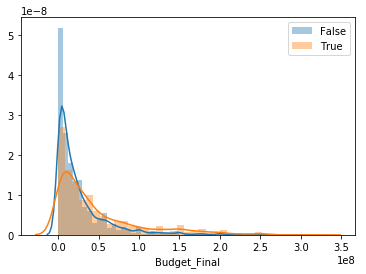

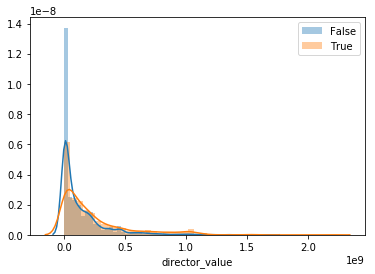

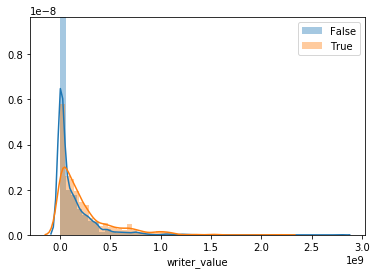

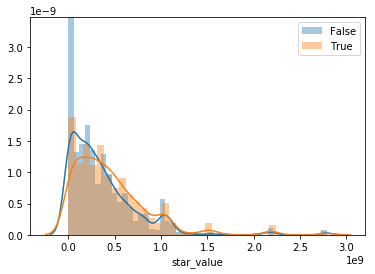

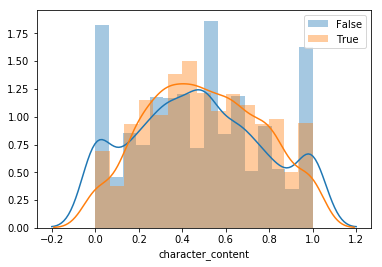

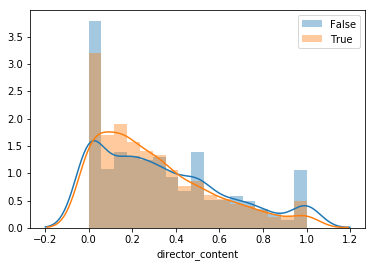

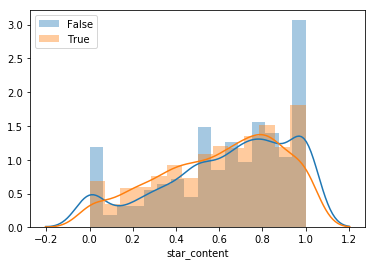

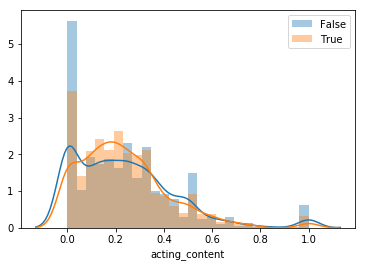

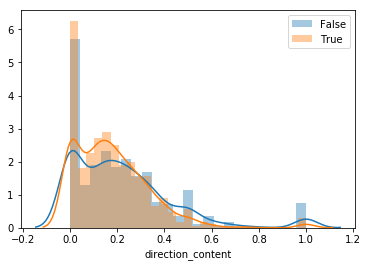

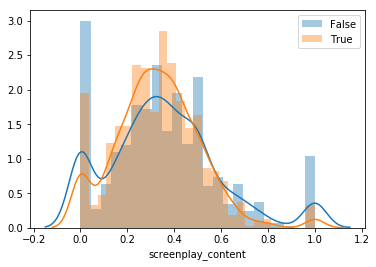

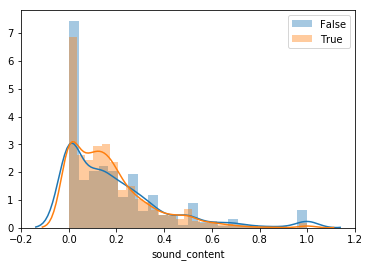

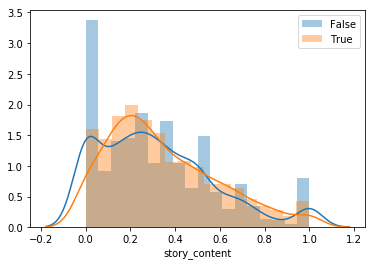

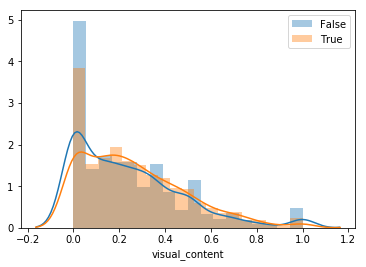

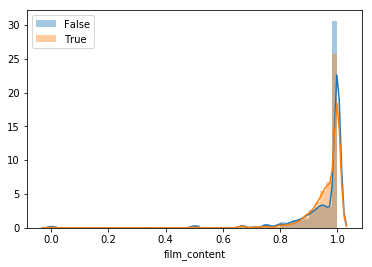

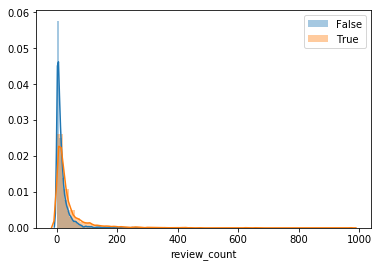

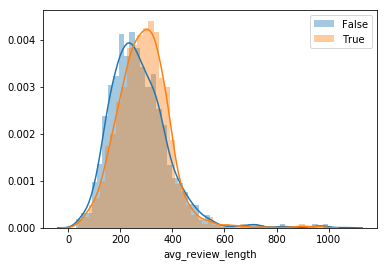

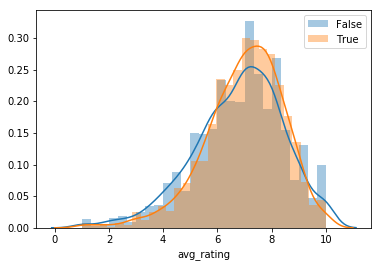

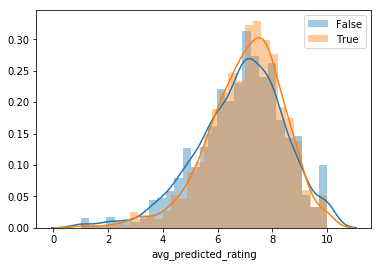

In [47]:
# plot the distribution for the numeric features
def distplot(col):
    sns.distplot(df[col][~df.Successful].dropna());
    sns.distplot(df[col][df.Successful].dropna());
    plt.legend(['False', 'True'])
    plt.show()

for col in ['Budget_Final', 'director_value', 'writer_value', 'star_value', 
            'character_content', 'director_content', 'star_content', 
            'acting_content', 'direction_content',
            'screenplay_content', 'sound_content', 'story_content',
            'visual_content', 'film_content',
            'review_count', 'avg_review_length', 'avg_rating', 'avg_predicted_rating']:
    distplot(col)

For those right-skewed numeric features, we applied log transformation.

In [48]:
for col in ['Budget_Final', 'director_value', 'writer_value', 'star_value', 'review_count']:
    X[col] = X[col].apply(np.log1p)
X.drop(['Rating_TV-14', 'Rating_TV-G', 'Rating_TV-MA', 'Rating_TV-PG', 'Rating_NC-17'], axis=1, inplace=True)

Finally, we plot the heatmap to see the correlation between different features.

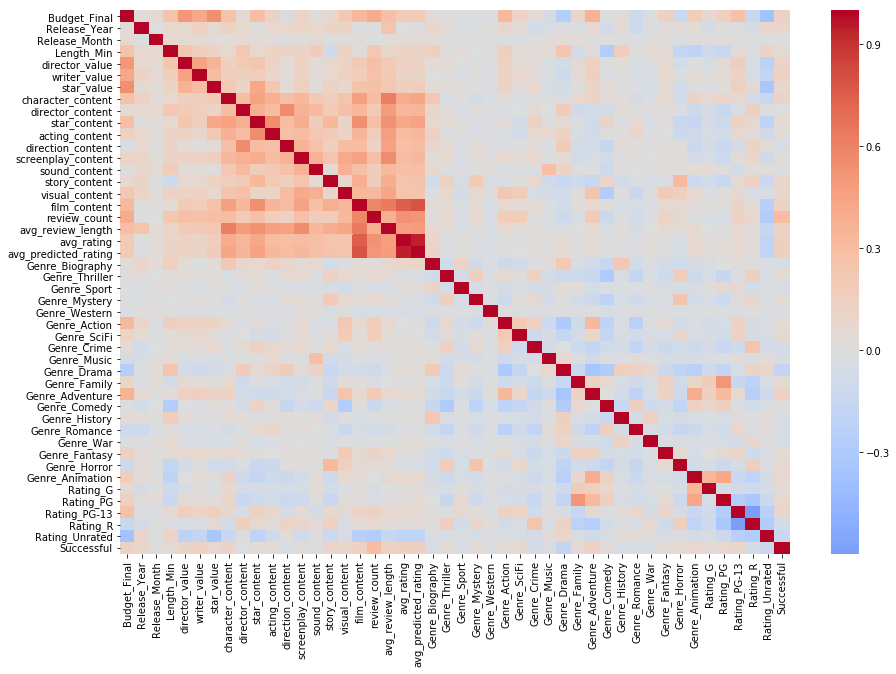

In [49]:
plt.figure(figsize=(15, 10))
sns.heatmap(pd.concat([X, y], axis=1).corr(), cmap="coolwarm", center=0);

# 4. Modeling
* In total, we have four sets of features. The basic movie features including the movie budget, release day and the person values that we have calculate in the feature engineering part. We will first build a baseline based on the basic movie features. We then will add the different text features in the model.

* We use two classification model here, the first one is logistic regression and the second one is random forest. We can find that, using naive method to count the appearance of person's name and using word2vec to expand the clue words both can improve the model's perforamce


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn import metrics

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
def classification_evaluation(clf, cols=X.columns):
    print(clf.__class__.__name__)
    clf.fit(X_train[cols], y_train)
    y_pred = clf.predict(X_test[cols])
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print('Accuracy: {}'.format(accuracy))
    print(classification_report(y_test, y_pred))
    
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    # Precision-Recall curve
    probs = clf.predict_proba(X_test[cols])
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, probs[:, 1])
    average_precision = metrics.average_precision_score(y_test, probs[:, 1])
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    plt.subplot(122)
    # Receiver Operating Characteristic (ROC) curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
    auc = metrics.auc(fpr, tpr)
    plt.step(fpr, tpr, color='b', alpha=0.2, where='post')
    plt.fill_between(fpr, tpr, step='post', alpha=0.2, color='b')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) curve: AUC={0:0.2f}'.format(auc))
    plt.show()

In [53]:
X.columns

Index(['Budget_Final', 'Release_Year', 'Release_Month', 'Length_Min',
       'director_value', 'writer_value', 'star_value', 'character_content',
       'director_content', 'star_content', 'acting_content',
       'direction_content', 'screenplay_content', 'sound_content',
       'story_content', 'visual_content', 'film_content', 'review_count',
       'avg_review_length', 'avg_rating', 'avg_predicted_rating',
       'Genre_Biography', 'Genre_Thriller', 'Genre_Sport', 'Genre_Mystery',
       'Genre_Western', 'Genre_Action', 'Genre_SciFi', 'Genre_Crime',
       'Genre_Music', 'Genre_Drama', 'Genre_Family', 'Genre_Adventure',
       'Genre_Comedy', 'Genre_History', 'Genre_Romance', 'Genre_War',
       'Genre_Fantasy', 'Genre_Horror', 'Genre_Animation', 'Rating_G',
       'Rating_PG', 'Rating_PG-13', 'Rating_R', 'Rating_Unrated'],
      dtype='object')

## 4.1 Logistic Model Performance

### 4.1.1Use Basic Movie Feature to predict 

LogisticRegression
Accuracy: 0.6460843373493976
             precision    recall  f1-score   support

      False       0.67      0.84      0.75       829
       True       0.55      0.32      0.41       499

avg / total       0.63      0.65      0.62      1328



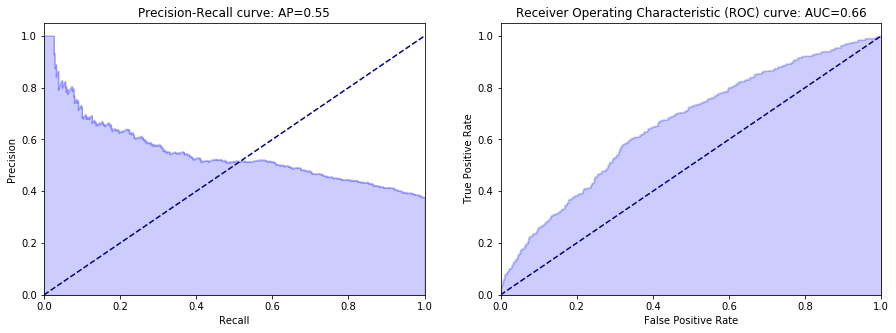

In [54]:
original_cols = ['Budget_Final', 'Release_Year', 'Release_Month', 'Length_Min',
                 'director_value', 'writer_value', 'star_value',
                 'Genre_Biography', 'Genre_Thriller', 'Genre_Sport', 'Genre_Mystery',
                 'Genre_Western', 'Genre_Action', 'Genre_SciFi', 'Genre_Crime',
                 'Genre_Music', 'Genre_Drama', 'Genre_Family', 'Genre_Adventure',
                 'Genre_Comedy', 'Genre_History', 'Genre_Romance', 'Genre_War',
                 'Genre_Fantasy', 'Genre_Horror', 'Genre_Animation', 'Rating_G',
                 'Rating_PG', 'Rating_PG-13', 'Rating_R', 'Rating_Unrated']
classification_evaluation(LogisticRegression(), cols=original_cols)

### 4.1.2 Use Naive Method to predict 

LogisticRegression
Accuracy: 0.6890060240963856
             precision    recall  f1-score   support

      False       0.72      0.83      0.77       829
       True       0.62      0.45      0.52       499

avg / total       0.68      0.69      0.68      1328



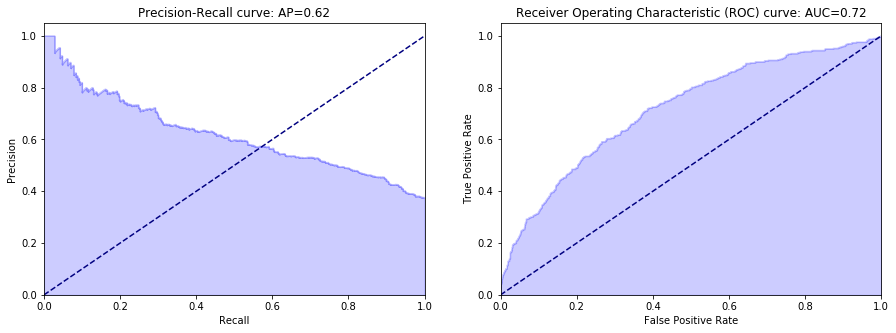

In [55]:
text_naive_cols = ['Budget_Final', 'Release_Year', 'Release_Month', 'Length_Min',
       'character_content',
       'director_content', 'star_content', 'review_count',
       'avg_review_length', 'avg_rating',
       'Genre_Biography', 'Genre_Thriller', 'Genre_Sport', 'Genre_Mystery',
       'Genre_Western', 'Genre_Action', 'Genre_SciFi', 'Genre_Crime',
       'Genre_Music', 'Genre_Drama', 'Genre_Family', 'Genre_Adventure',
       'Genre_Comedy', 'Genre_History', 'Genre_Romance', 'Genre_War',
       'Genre_Fantasy', 'Genre_Horror', 'Genre_Animation', 'Rating_G',
       'Rating_PG', 'Rating_PG-13', 'Rating_R', 'Rating_Unrated']
classification_evaluation(LogisticRegression(), cols=text_naive_cols)

### 4.1.3 Use word2vector to expand the clue words

LogisticRegression
Accuracy: 0.6980421686746988
             precision    recall  f1-score   support

      False       0.72      0.83      0.78       829
       True       0.63      0.47      0.54       499

avg / total       0.69      0.70      0.69      1328



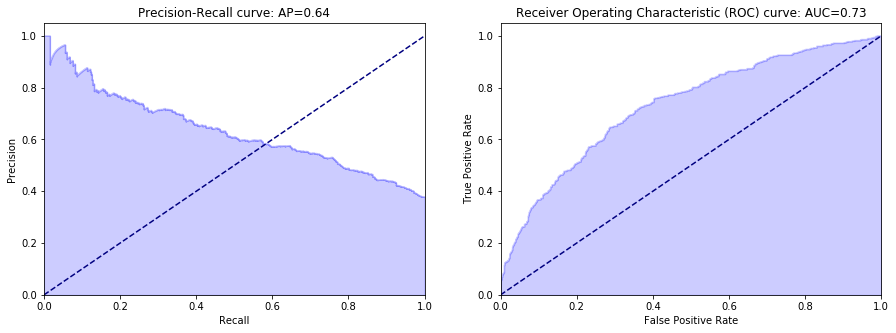

In [56]:
text_w2v_cols = ['Budget_Final', 'Release_Year', 'Release_Month', 'Length_Min',
               'director_value', 'writer_value', 'star_value', 'character_content',
               'direction_content', 'screenplay_content', 'sound_content',
               'story_content', 'visual_content', 'film_content', 'review_count',
               'avg_review_length', 'avg_rating',
               'Genre_Biography', 'Genre_Thriller', 'Genre_Sport', 'Genre_Mystery',
               'Genre_Western', 'Genre_Action', 'Genre_SciFi', 'Genre_Crime',
               'Genre_Music', 'Genre_Drama', 'Genre_Family', 'Genre_Adventure',
               'Genre_Comedy', 'Genre_History', 'Genre_Romance', 'Genre_War',
               'Genre_Fantasy', 'Genre_Horror', 'Genre_Animation', 'Rating_G',
               'Rating_PG', 'Rating_PG-13', 'Rating_R', 'Rating_Unrated']
classification_evaluation(LogisticRegression(), cols=text_w2v_cols)

### 4.1.4 Use predicted review rating to predcit

LogisticRegression
Accuracy: 0.7033132530120482
             precision    recall  f1-score   support

      False       0.73      0.83      0.78       829
       True       0.64      0.49      0.55       499

avg / total       0.70      0.70      0.69      1328



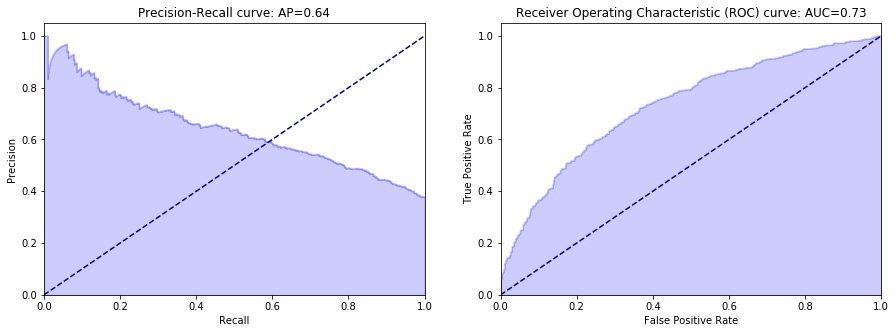

In [57]:
text_predicted_rating_cols = ['Budget_Final', 'Release_Year', 'Release_Month', 'Length_Min',
       'director_value', 'writer_value', 'star_value', 'acting_content',
       'direction_content', 'screenplay_content', 'sound_content',
       'story_content', 'visual_content', 'film_content', 'review_count',
       'avg_review_length', 'avg_predicted_rating',
       'Genre_Biography', 'Genre_Thriller', 'Genre_Sport', 'Genre_Mystery',
       'Genre_Western', 'Genre_Action', 'Genre_SciFi', 'Genre_Crime',
       'Genre_Music', 'Genre_Drama', 'Genre_Family', 'Genre_Adventure',
       'Genre_Comedy', 'Genre_History', 'Genre_Romance', 'Genre_War',
       'Genre_Fantasy', 'Genre_Horror', 'Genre_Animation', 'Rating_G',
       'Rating_PG', 'Rating_PG-13', 'Rating_R', 'Rating_Unrated']
classification_evaluation(LogisticRegression(), cols=text_predicted_rating_cols)

## 4.2 Random Forest Model Performance

### 4.2.1Use Basic Movie Feature to predict 

RandomForestClassifier
Accuracy: 0.6754518072289156
             precision    recall  f1-score   support

      False       0.70      0.85      0.77       829
       True       0.61      0.38      0.47       499

avg / total       0.66      0.68      0.65      1328



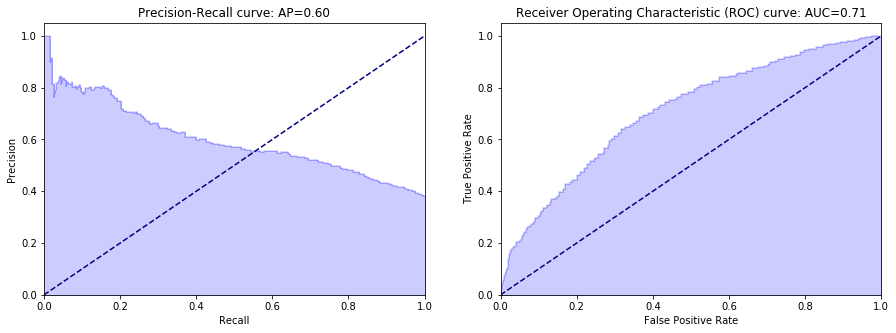

In [58]:
classification_evaluation(RandomForestClassifier(n_estimators=200), cols=original_cols)

### 4.2.2 Use Naive Method to predict 

RandomForestClassifier
Accuracy: 0.7070783132530121
             precision    recall  f1-score   support

      False       0.73      0.85      0.78       829
       True       0.65      0.47      0.55       499

avg / total       0.70      0.71      0.69      1328



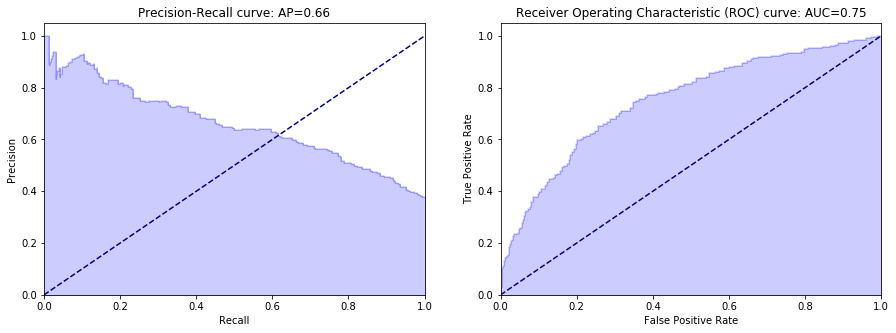

In [59]:
classification_evaluation(RandomForestClassifier(n_estimators=200), cols=text_naive_cols)

### 4.2.3 Use word2vector to expand the clue words

RandomForestClassifier
Accuracy: 0.7168674698795181
             precision    recall  f1-score   support

      False       0.73      0.86      0.79       829
       True       0.68      0.47      0.56       499

avg / total       0.71      0.72      0.70      1328



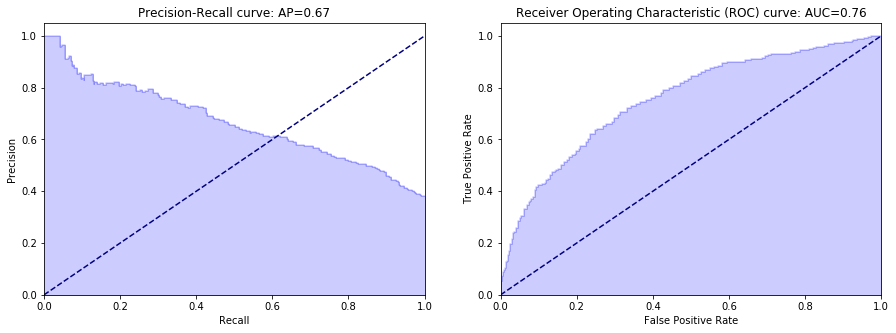

In [60]:
classification_evaluation(RandomForestClassifier(n_estimators=200), cols=text_w2v_cols)

### 4.2.4 Use predicted review rating to predcit

RandomForestClassifier
Accuracy: 0.7168674698795181
             precision    recall  f1-score   support

      False       0.73      0.86      0.79       829
       True       0.68      0.47      0.56       499

avg / total       0.71      0.72      0.70      1328



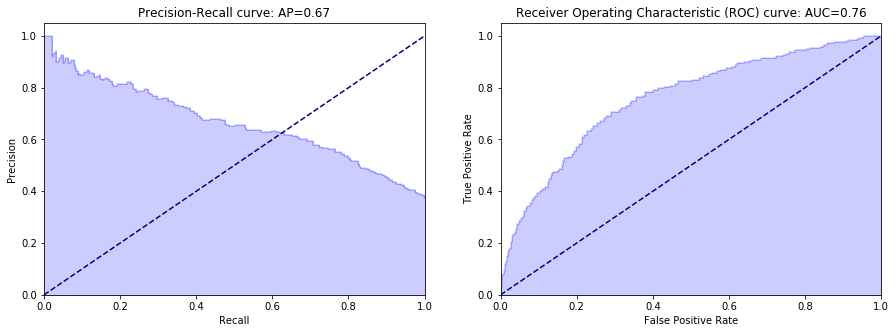

In [61]:
classification_evaluation(RandomForestClassifier(n_estimators=200), cols=text_predicted_rating_cols)

# 5. Model interpretation

In [62]:
clf = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train[text_w2v_cols], y_train)

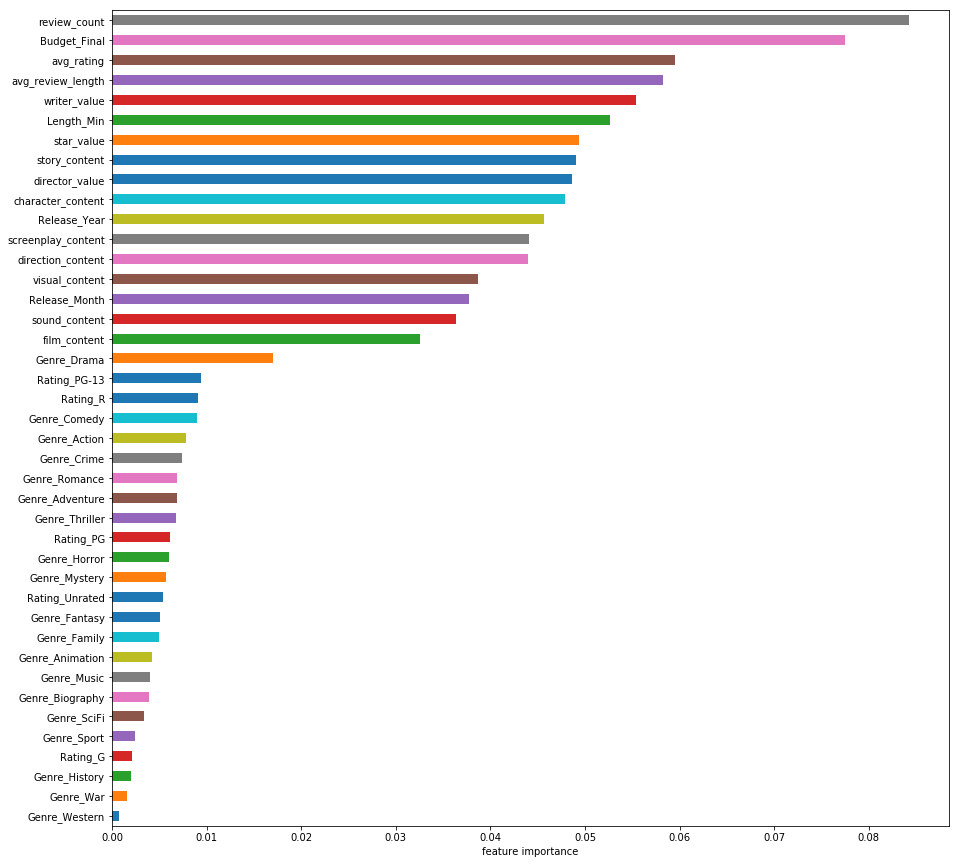

In [63]:
imp = pd.Series({feature: importance for feature, importance in zip(text_w2v_cols, clf.feature_importances_)})
imp.sort_values().plot.barh(figsize=(15, 15))
plt.xlabel('feature importance');